# Model Selection

This notebook starts with conditioned data. The data is not yet in the "wide" table that would show several preceeding hours of data. I wanted to start with the simple hour prediction to see how accurate of a model could be made.

In [61]:
import seaborn as sns
import os
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import glob
import dateutil
import datetime 
from datetime import date, timedelta

from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, validation_curve
from sklearn.linear_model import *
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline

In [44]:
df = pd.read_csv('combined_data.csv')
df.head()

,Unnamed: 0,dayIndex,hourIndex,dateOnly,hSamples,usage,weatherAES,dayIndexEco,hourIndexEco,dateOnlyEco,...,wind,coolStage1,heatStage1,auxStage1,fan,thermT,thermHum,thermMotion,sensT,sensMotion
0,0,0,0,2023-09-01,1,0.7500,65.0,0,0,2023-09-01,...,0.0,1095.0,0.0,0.0,1230.0,71.275000,44.250000,0.0,71.716667,0.0
1,1,0,1,2023-09-01,1,0.5592,64.0,0,1,2023-09-01,...,0.0,735.0,0.0,0.0,825.0,71.225000,44.750000,0.0,71.650000,0.0
2,2,0,2,2023-09-01,1,0.5448,63.0,0,2,2023-09-01,...,0.0,735.0,0.0,0.0,825.0,71.200000,44.750000,0.0,71.466667,0.0
3,3,0,3,2023-09-01,1,0.5460,61.0,0,3,2023-09-01,...,0.0,750.0,0.0,0.0,840.0,71.208333,44.750000,0.0,71.275000,0.0
4,4,0,4,2023-09-01,1,0.4236,60.0,0,4,2023-09-01,...,0.0,420.0,0.0,0.0,465.0,71.241667,44.916667,0.0,71.200000,0.0


In [45]:
df["dateOnly"] = pd.to_datetime(df["dateOnly"],
               format='%Y-%m-%d')
df.dateOnly

0      2023-09-01
1      2023-09-01
2      2023-09-01
3      2023-09-01
4      2023-09-01
          ...    
5107   2024-03-31
5108   2024-03-31
5109   2024-03-31
5110   2024-03-31
5111   2024-03-31
Name: dateOnly, Length: 5112, dtype: datetime64[ns]

In [46]:
# need to make the date and hour as the index datetime
fullTime = []
for i in range(len(df)):
    fullTime.append(df["dateOnly"].loc[i].replace(hour=df["hourIndex"].loc[i]))

df["fullTime"] = fullTime
df["fullTime"]

# from lab notebook
df.set_index('fullTime', inplace=True)
df.sort_index(inplace=True)

df.head()

,Unnamed: 0,dayIndex,hourIndex,dateOnly,hSamples,usage,weatherAES,dayIndexEco,hourIndexEco,dateOnlyEco,...,wind,coolStage1,heatStage1,auxStage1,fan,thermT,thermHum,thermMotion,sensT,sensMotion
fullTime,,,,,,,,,,,,,,,,,,,,,
2023-09-01 00:00:00,0,0,0,2023-09-01,1,0.7500,65.0,0,0,2023-09-01,...,0.0,1095.0,0.0,0.0,1230.0,71.275000,44.250000,0.0,71.716667,0.0
2023-09-01 01:00:00,1,0,1,2023-09-01,1,0.5592,64.0,0,1,2023-09-01,...,0.0,735.0,0.0,0.0,825.0,71.225000,44.750000,0.0,71.650000,0.0
2023-09-01 02:00:00,2,0,2,2023-09-01,1,0.5448,63.0,0,2,2023-09-01,...,0.0,735.0,0.0,0.0,825.0,71.200000,44.750000,0.0,71.466667,0.0
2023-09-01 03:00:00,3,0,3,2023-09-01,1,0.5460,61.0,0,3,2023-09-01,...,0.0,750.0,0.0,0.0,840.0,71.208333,44.750000,0.0,71.275000,0.0
2023-09-01 04:00:00,4,0,4,2023-09-01,1,0.4236,60.0,0,4,2023-09-01,...,0.0,420.0,0.0,0.0,465.0,71.241667,44.916667,0.0,71.200000,0.0


# Data Exploration and Visualization

1. Identify the good data only, that is the rows with 1 hSamples and 12 fiveMinSamples -> used pd.dropna
2. plot the pairplot of most important variable
3. try fitting a regression model using the "most important variables"
4. retry models while using various parameters

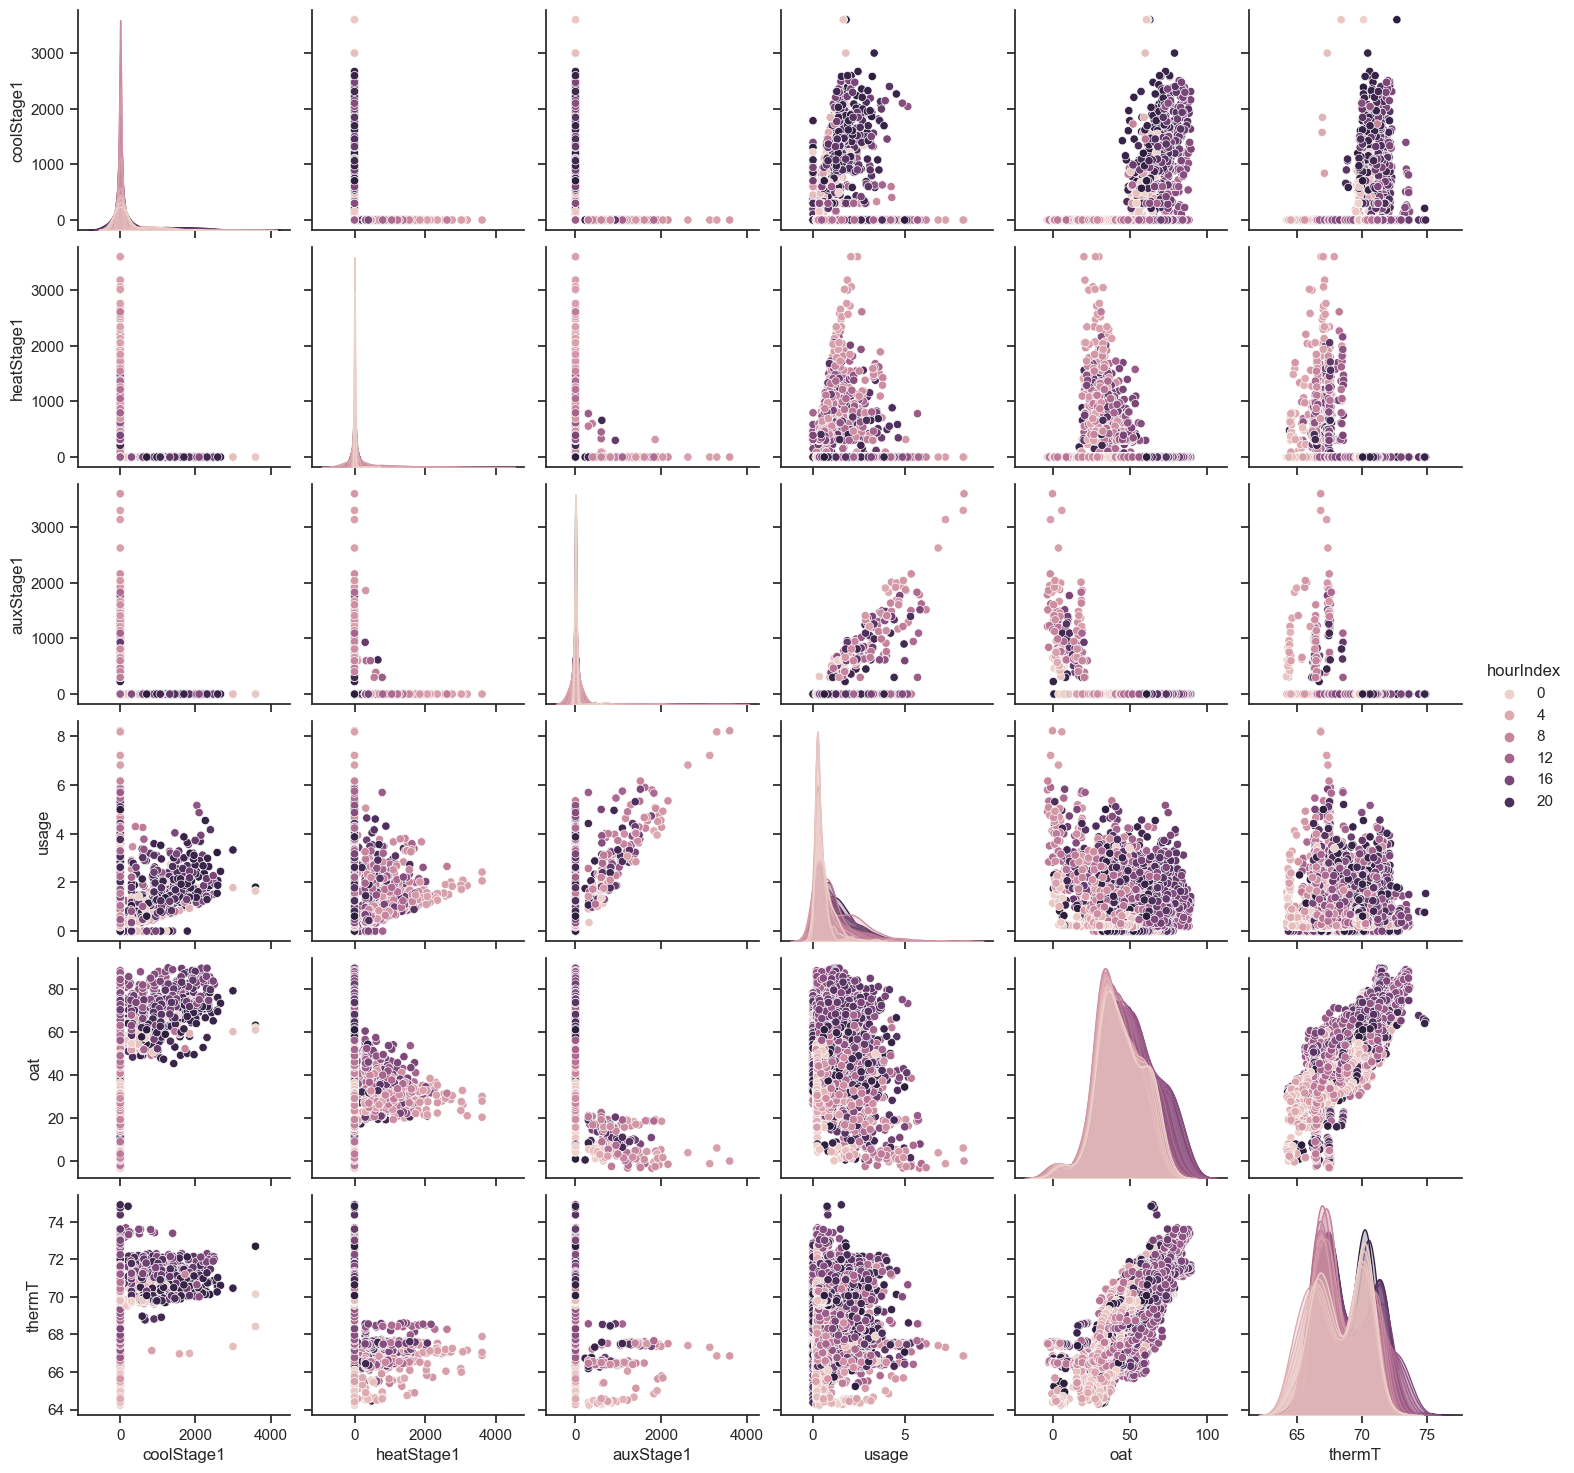

In [28]:
smallDataset = ["hourIndex","coolStage1", "heatStage1", "auxStage1", "usage", "oat", "thermT"]
#smalldf = df[smallDataset].dropna() #Do not do this yet.
smalldf = df[smallDataset]
sns.set_theme(style="ticks")

sns.pairplot(smalldf, hue="hourIndex")

# Simple Data Set

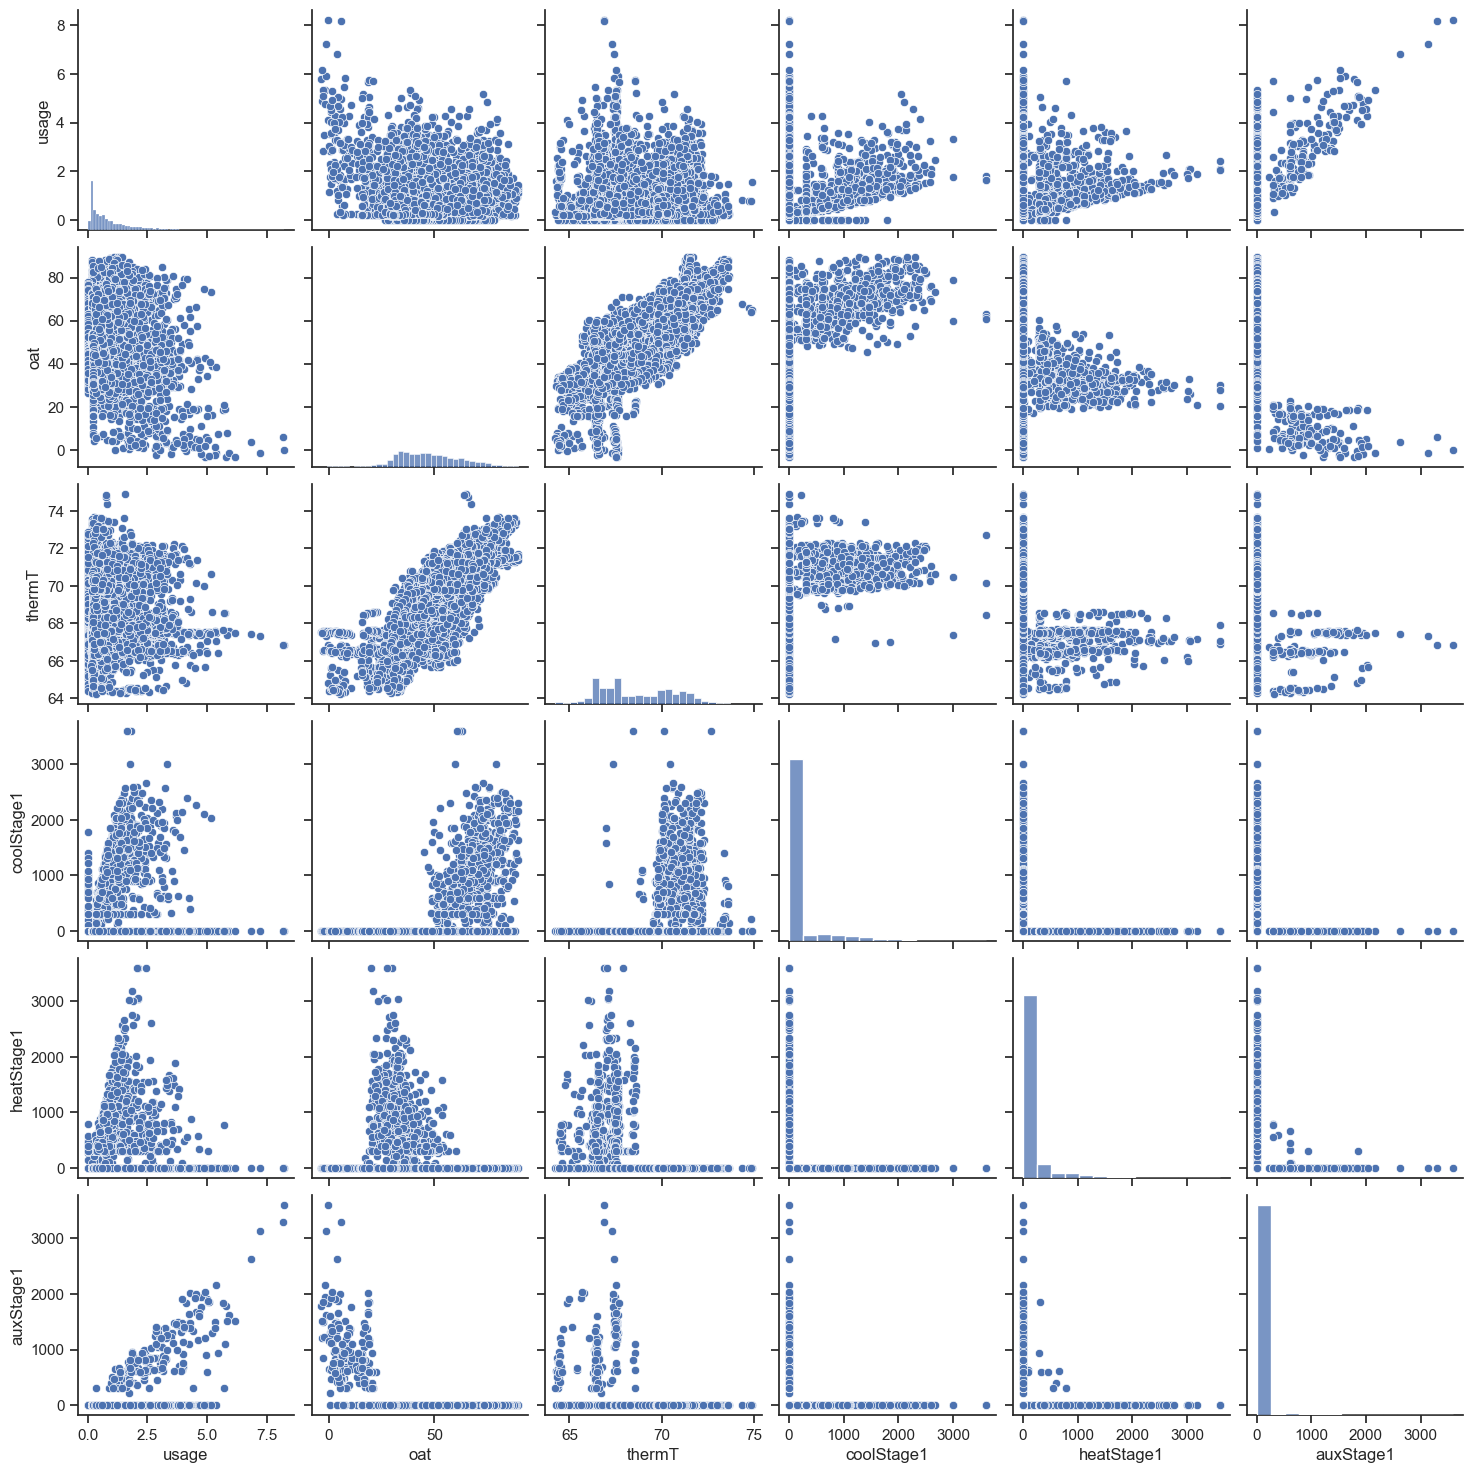

In [76]:
simpleDataset = ["usage", "oat", "thermT"]
runningparams = ["coolStage1", "heatStage1", "auxStage1"]
#smalldf = df[smallDataset].dropna() #Do not do this yet.

simpledf = df[simpleDataset + runningparams]

#simpledf['runtime'] = df[runningparams].sum(axis=1)

simpledf.head()


sns.set_theme(style="ticks")
sns.pairplot(simpledf)

# Simple Data Linear Regression
There are still a lot of NaNs in the dataset. for some reason, the data logging would randomly drop out. To control for this, we will replace the NaNs with the previous 4 hours... This isn't the best option but it will do for now.

In [77]:
pipe = make_pipeline(KNNImputer(n_neighbors=2, weights="uniform"), LinearRegression())

X = simpledf.drop(['usage'], axis=1)
y = simpledf.usage

train, test = train_test_split(simpledf, test_size=0.2)
X_train = train.drop('usage', axis=1)
y_train = train.usage

X_test = test.drop('usage', axis=1)
y_test = test.usage

Mean squared error (test error): 0.57
Coefficient of determination: 0.27
Mean score of 0.33 with a standard deviation of 0.02


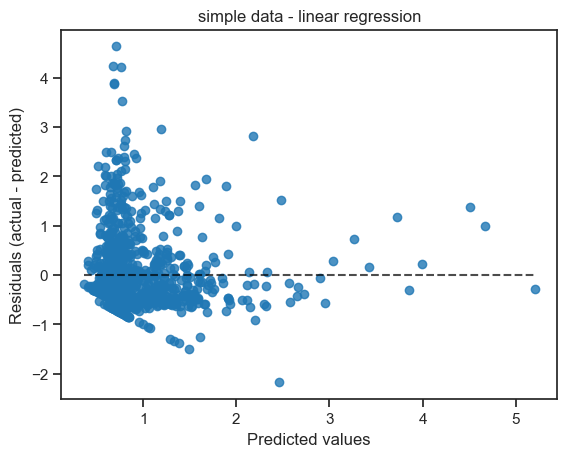

In [78]:
pipe.fit(X_train, y_train)
Y_pred = pipe.predict(X_test)

print("Mean squared error (test error): %.2f" % mean_squared_error(y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, Y_pred))

k_fold = RepeatedKFold(n_splits=3)
scores = cross_val_score(pipe, X, y, cv=k_fold)
print("Mean score of %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

display = PredictionErrorDisplay(y_true=y_test, y_pred=Y_pred)
display.plot()
plt.title("simple data - linear regression")
plt.show()

# Wide Matrix Fit

In [67]:
# I am still using my weird shift method because it worked and time is short
colNames = smalldf.columns
minusNums = ['_1','_2','_3','_4']

n=4

shiftdf =[]
repeatRow = smalldf.iloc[[0]]
thisdf =smalldf
for i in range(n):
    thisdf = pd.concat([repeatRow, thisdf], ignore_index=True)
    dictionary = dict(zip(colNames.to_list(), (colNames + minusNums[i]).to_list()))
    newdf = thisdf.rename(columns=dictionary)
    #print(newdf.columns)
    shiftdf.append(newdf)
    

widedf = smalldf.join(shiftdf[:])
#now remove the top and bottom 4 rows

widedf.drop(widedf.tail(n).index,inplace=True) # drop last n rows
widedf.drop(widedf.head(n).index,inplace=True) # drop first n rows

#the widedf now includes the preceeding 4 hours for each observation
widedf.head()
#widedf=widedf.dropna()

,hourIndex,coolStage1,heatStage1,auxStage1,usage,oat,thermT,hourIndex_1,coolStage1_1,heatStage1_1,...,usage_3,oat_3,thermT_3,hourIndex_4,coolStage1_4,heatStage1_4,auxStage1_4,usage_4,oat_4,thermT_4
fullTime,,,,,,,,,,,,,,,,,,,,,
2023-09-01 04:00:00,4.0,420.0,0.0,0.0,0.4236,59.25,71.241667,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-01 05:00:00,5.0,0.0,0.0,0.0,0.6888,58.25,71.475000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-01 06:00:00,6.0,0.0,0.0,0.0,0.2760,56.75,71.741667,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-01 07:00:00,7.0,0.0,0.0,0.0,1.4568,56.55,71.958333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-01 08:00:00,8.0,0.0,0.0,0.0,0.2916,58.20,72.091667,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
pipe = make_pipeline(KNNImputer(n_neighbors=2, weights="uniform"), LinearRegression())

X = widedf.drop(['usage', 'usage_1', 'usage_2', 'usage_3', 'usage_4'], axis=1)
y = widedf.usage

train, test = train_test_split(widedf, test_size=0.2)
X_train = train.drop('usage', axis=1)
y_train = train.usage

X_test = test.drop('usage', axis=1)
y_test = test.usage

Mean squared error (test error): 0.56
Coefficient of determination: 0.40
Mean score of 0.40 with a standard deviation of 0.03


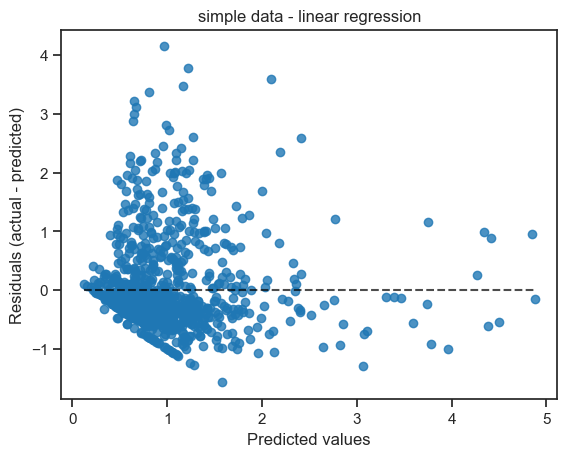

In [75]:
pipe.fit(X_train, y_train)
Y_pred = pipe.predict(X_test)

print("Mean squared error (test error): %.2f" % mean_squared_error(y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, Y_pred))

k_fold = RepeatedKFold(n_splits=3)
scores = cross_val_score(pipe, X, y, cv=k_fold)
print("Mean score of %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

display = PredictionErrorDisplay(y_true=y_test, y_pred=Y_pred)
display.plot()
plt.title("simple data - linear regression")
plt.show()

In [23]:
widedf[["oat","oat_1","oat_2","oat_3","oat_4"]]

,oat,oat_1,oat_2,oat_3,oat_4
4,59.25,60.20,62.05,63.45,65.00
5,58.25,59.25,60.20,62.05,63.45
6,56.75,58.25,59.25,60.20,62.05
7,56.55,56.75,58.25,59.25,60.20
8,58.20,56.55,56.75,58.25,59.25
...,...,...,...,...,...
5079,74.90,68.00,68.20,67.60,66.10
5080,75.20,64.50,68.00,68.20,67.60
5081,75.20,62.50,64.50,68.00,68.20
5082,73.60,61.30,62.50,64.50,68.00


In [32]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import PredictionErrorDisplay

linModel = LinearRegression()
linModel.fit(X_train, y_train)
Y_pred = linModel.predict(X_test)

print("Mean squared error (test error): %.2f" % mean_squared_error(y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, Y_pred))

k_fold = RepeatedKFold(n_splits=3)
scores = cross_val_score(linModel, X, y, cv=k_fold)
print("Mean score of %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

display = PredictionErrorDisplay(y_true=y_test, y_pred=Y_pred)
display.plot()
plt.title("wide data - linear regression")
plt.show()


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Regression Trees on single hour dataset
Using the lab example from the book...

In [12]:
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset 
import sklearn.model_selection as skm

from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR,
plot_tree ,
export_text)
from sklearn.metrics import (accuracy_score ,
log_loss) 
from sklearn.ensemble import \
(RandomForestRegressor as RF, GradientBoostingRegressor as GBR)

from ISLP import load_data , confusion_table 
from ISLP.models import ModelSpec as MS

In [13]:
model = MS(smalldf.columns.drop('usage'), intercept=False) 
D = model.fit_transform(smalldf)
feature_names = list(D.columns)
X = np.asarray(D)

In [15]:
from sklearn.model_selection import train_test_split

X = smalldf.drop('usage', axis=1)
y = smalldf.usage

train, test = train_test_split(smalldf, test_size=0.2)
X_train = train.drop('usage', axis=1)
y_train = train.usage

X_test = test.drop('usage', axis=1)
y_test = test.usage

In [22]:
# train, test already created
print(feature_names)
X_train

['hourIndex', 'coolStage1', 'heatStage1', 'auxStage1', 'oat', 'thermT']


,hourIndex,coolStage1,heatStage1,auxStage1,oat,thermT
359,23,1305.0,0.0,0.0,63.15,70.166667
4977,9,0.0,0.0,0.0,55.90,70.475000
2727,15,0.0,0.0,0.0,51.40,67.566667
2063,23,0.0,0.0,0.0,33.55,65.841667
486,6,0.0,0.0,0.0,63.25,71.275000
...,...,...,...,...,...,...
2869,13,0.0,345.0,0.0,38.00,66.400000
4875,3,0.0,0.0,0.0,33.50,66.816667
769,1,1065.0,0.0,0.0,66.25,69.866667
1113,9,0.0,0.0,0.0,49.85,70.016667


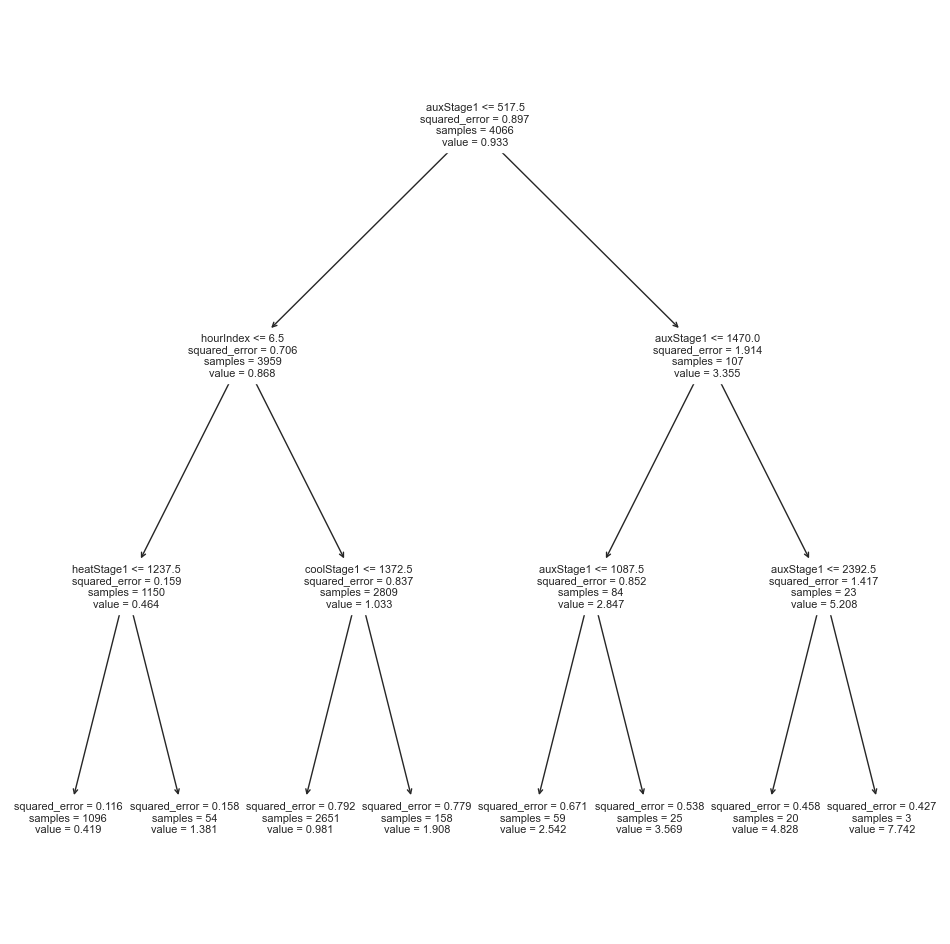

In [21]:
reg = DTR(max_depth=3) 
reg.fit(X_train, y_train)
plt.figure(figsize=(12,12))
plot_tree(reg, feature_names=feature_names);

In [18]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train) 
kfold = skm.KFold(5,
shuffle=True,
random_state=10) 
grid = skm.GridSearchCV(reg,
{'ccp_alpha': ccp_path.ccp_alphas},
refit=True,
cv=kfold, scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

In [19]:
best_ = grid.best_estimator_
print("MSE:", np.mean((y_test - best_.predict(X_test))**2))

MSE: 0.6152471972946525


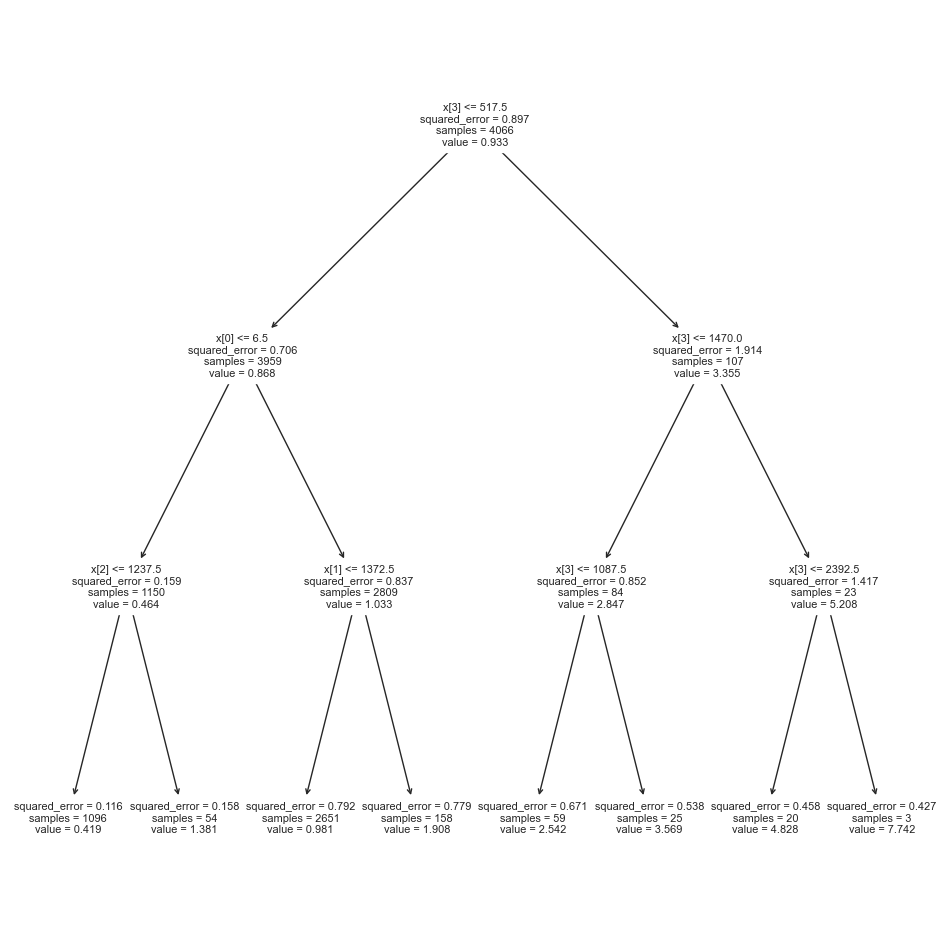

In [20]:
plt.figure(figsize=(12,12))
plot_tree(G.best_estimator_);

In [51]:
smalldf.usage.mean()

0.9301690340350186